# Mutational antigenic profiling of antibody 2B06
[Mutational antigenic profiling](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271) of antibody [FluA-20](https://www.sciencedirect.com/science/article/pii/S0092867419303976?via%3Dihub) against the HA from A/WSN/1933 (H1N1) was performed by Lauren Gentles in the Bloom lab using antibody from James Crowe's lab.

## Data and analysis

The computer code for all the analysis is on [GitHub here](https://github.com/jbloomlab/FluA-20_D2_MAP_in_vivo).

The raw data in CSV format is [here](results/diffsel/tidy_diffsel.csv).

A full-gene logo plot of the immune selection at site using **H3 numbering** is [here](results/diffsel/FluA-20_diffsel.pdf). A more compact version in H3 numbering that zooms in on key sites is [here](results/diffsel/line_and_logo_plot.pdf).


## Interactive PDB structure
Note: *It may take a minute for the structure to render, please be patient.*

The structure below is PDB [1rvx](https://www.rcsb.org/structure/1RVX), and you can click and zoom (scroll) to see specific sites.
In the structure and the logo plots shown below, the numbering is the H1 scheme used in PDB 1rvx.
To convert between this and other numbering schemes, see the actual data file linked above.

In [34]:
# This notebook shows logo plots and interactive structure widgets.
# It is set up so that it can be parameterized by papermill.
# It is designed so that it can be run in appmode
# (https://github.com/oschuett/appmode), and for that reason has
# comments written mostly in code cells rather than Markdown.

In [35]:
# import Python modules

import io
import os

from IPython.display import display, Image

import matplotlib.image
import matplotlib.pyplot as plt

import nglview

import pandas as pd

import yaml

from dmslogo import facet_plot
from dms_struct.colorschemes import ValueToColorMap
from dms_struct.struct_widget import colored_struct

In [18]:
# This cell is tagged `parameters` to enable papermill parameterization
# See: https://papermill.readthedocs.io/en/latest/usage-parameterize.html

data_csv = 'results/diffsel/tidy_diffsel.csv'  # CSV file with tidy data frame to plot
query_str = None  # query data frame using this str to get just subset to plot
mut_metric = 'mutdiffsel'  # mutation-level selection metric
site_metric = 'positive_diffsel'  # site-level selection metric
facet_col = 'antibody'  # column specifying each subset to plot, for instance serum or antibody
isite_col = 'isite'  # column specifying sites in sequential integer numbering
site_col = 'PDB_1rvx_site_label'  # column specifying site number as str
pdb_chain_col = 'PDB_1rvx_chain'  # column specifying PDB chain
pdb_site_col = 'PDB_1rvx_site'  # column specifying PDB site
zoom_col = 'sig'  # column indicating sites to zoom in logo and struct
wildtype_col = 'wildtype'  # column indicating wildtype identity at site
mutation_col = 'mutation'  # column indicating amino-acid mutant

# representation for structure, such as `cartoon`, `surface`, `spacefill`
representation = ['surface', 'spacefill']

outdir = './structure_images/'  # output directory for structure images

pdb = '1rvx'  # PDB ID
# orientation of structure: https://github.com/arose/nglview/issues/785#issuecomment-487409212
orientation = [-199.32953041594806,
               -0.6174687269471241,
               -60.0388802064949,
               0,
               60.00620431309924,
               5.178455444576969,
               -199.27430393297303,
               0,
               2.084549831010037,
               -208.111654524796,
               -4.780400626634953,
               0,
               -79.48731006124625,
               -15.095934561750575,
               -20.81355945679667,
               1]

# specs for panel of structure images created as image file
panel_height = 3.75  # height of panel plot
panel_top = 0.9  # top margin of panel
panel_wspace = 0.4  # space between subplots
panel_legend_width = 0.3  # width of legend relative to subplots
panel_fig = './structure_images/struct_panel.png'  # created panel imaged file

# Do structures and logo plots have separate scales for immune selection coloring?
separatescale = True

Scale bar mapping the strength of immune selection to the colors in the structure and logo plots:

Immune selection color-scale is different for each structure:


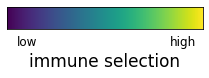

In [19]:
# read the data
data = pd.read_csv(data_csv).query('isite > 16 & isite < 502') # ignore sites not in PDB ectodomain

# query data if applicable
if query_str:
    data = data.query(query_str)

# get mutation-level data for logo plot plotting
mut_df = (data
          [[facet_col, isite_col, site_col, pdb_chain_col, pdb_site_col,
            zoom_col, wildtype_col, mutation_col, mut_metric, site_metric]]
          .assign(**{site_col: lambda x: x[site_col].astype('str')})
          .assign(site_label=lambda x: x[wildtype_col] + x[site_col],
                  facet_spaces=lambda x: x[facet_col].str.replace('-', ' '))
          )

if separatescale:
    print('Immune selection color-scale is different for each structure:')
    mut_df_list = []
    for facet, facet_df in mut_df.groupby(facet_col, sort=False):
        colormapper = ValueToColorMap(0, facet_df[site_metric].max())
        mut_df_list.append(facet_df.assign(color=lambda x: (x[site_metric]
                                               .apply(colormapper.val_to_color))))
    mut_df = pd.concat(mut_df_list)
else:
    print("Immune selection color-scale is shared across structures:")
    colormapper = ValueToColorMap(0, mut_df[site_metric].max())
    mut_df = mut_df.assign(color=lambda x: (x[site_metric]
                                           .apply(colormapper.val_to_color)))

# get site level data for structure images
site_df = (mut_df
           [[facet_col, pdb_chain_col, pdb_site_col, zoom_col, 'color']]
           .drop_duplicates()
           )

# show the scale bar
fig, _ = colormapper.scale_bar(label='immune selection',
                               orientation='horizontal',
                               low_high_ticks_only=separatescale)
display(fig)
plt.close(fig)

In [29]:
%%capture
# `%%capture` prevents plots from being shown

# get logo plots for each facet
logoplots = {}
for facet, facet_df in mut_df.groupby(facet_col, sort=False):
    if separatescale:
        ymax = facet_df[site_metric].max()
    else:
        ymax = mut_df[site_metric].max()   
    assert ymax > 0
    dy = 0.055 * ymax  # extra for y-limits
    fig, _ = facet_plot(facet_df,
                        gridrow_col='facet_spaces',
                        x_col=isite_col,
                        show_col=zoom_col,
                        draw_line_kwargs={'height_col': site_metric,
                                          'xtick_col': site_col,
                                          'ylabel': 'immune selection'},
                        draw_logo_kwargs={'letter_col': mutation_col,
                                          'letter_height_col': mut_metric,
                                          'xtick_col': 'site_label',
                                          'color_col': 'color',
                                          'xlabel': site_col,
                                          'ylabel': 'immune selection',
                                          'clip_negative_heights': True},
                        line_titlesuffix='site-level selection',
                        logo_titlesuffix='mutation-level selection',
                        share_ylim_across_rows=False,
                        share_xlabel=True,
                        share_ylabel=True,
                        height_per_ax=2,
                        set_ylims=(-dy, ymax + dy)
                        )
    logoplots[facet] = fig

In [30]:
# get structure widgets for each facet
widgets = {}
for facet, facet_df in site_df.groupby(facet_col, sort=False):
    w = colored_struct(pdb=pdb,
                       prop_df=facet_df.query(f"not {pdb_site_col}.isnull()"),
                       chain_col=pdb_chain_col,
                       site_col=pdb_site_col,
                       representation=representation,
                       highlight_col=zoom_col,
                       orientation=orientation,
                       show_other='protein',
                       )
    widgets[facet] = w

Maps of immune selection:
 - The line plots show the total selection at each site.
 - The logo plots show selection for each mutation at key sites.
 - The structures show the selection at each site.

------------------------ FluA 20 ------------------------


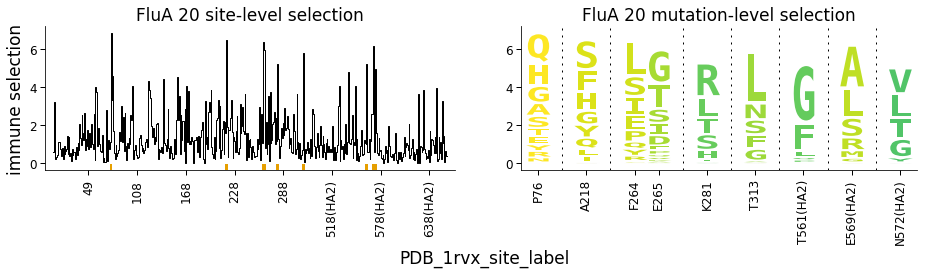

NGLWidget()

In [31]:
# show logo plots and widgets
for facet, logofig in logoplots.items():
    print('-' * 24 + f" {facet.replace('-', ' ')} " + '-' * 24)
    display(logofig)
    display(widgets[facet])

In [32]:
mat = widgets[facet]._camera_orientation
mat

[]

In [33]:
images = {}
for facet, w in widgets.items():
    images[facet] = w.render_image(factor=4, trim=True)

In [25]:
# YOU MUST WAIT FOR THE IMAGES ABOVE TO RENDER BEFORE RUNNING THE FOLLOWING CELLS

In [26]:
os.makedirs(outdir, exist_ok=True)
png_files = {}
for facet, image in images.items():
    png_file = os.path.join(outdir, f"{facet}.png")
    with open(png_file, 'wb') as f:
        if image:
            f.write(image.value)
    png_files[facet] = png_file

In [27]:
# Show all structures in a panel.
# Follow basic idea here to show PNGs as matplotlib plot:
# https://stackoverflow.com/a/50569248

mpimages = {}
for facet, png in png_files.items():
    with open(png, 'rb') as f:
        contents = f.read()
    if contents:
        mpimages[facet] = matplotlib.image.imread(png)
    else:
        dummyfig = plt.figure(figsize=(panel_height, panel_height))
        plt.xticks([], fig=dummyfig)
        plt.yticks([], fig=dummyfig)
        plt.text(0.5, 0.5,
                 f"Empty PNG for {facet}.\n"
                 'Did you allow widgets to render\n'
                 'before running subsequent cells?',
                 va='center', ha='center')
        with io.BytesIO() as f:
            dummyfig.savefig(f, format='png')
            f.seek(0)
            mpimages[facet] = matplotlib.image.imread(f)
        plt.close(dummyfig)

aspects = [img.shape[1] / img.shape[0] for img in mpimages.values()]
aspects.insert(0, sum(aspects) / len(aspects) * panel_legend_width * 0.5)
nax = len(aspects)
figwidth = panel_height * sum(aspects) * (1 + panel_wspace)
avgpanelwidth = sum(aspects) / len(aspects) * panel_height

fig, axes = plt.subplots(
                nrows=1,
                ncols=nax,
                figsize=(figwidth, panel_height),
                gridspec_kw={'width_ratios': aspects},
                )

fig.subplots_adjust(left=0.5 * panel_legend_width / sum(aspects),
                    right=1 - panel_wspace * avgpanelwidth / figwidth,
                    bottom=0.03, top=panel_top,
                    wspace=panel_wspace, hspace=0)

_ = colormapper.scale_bar(label='immune selection',
                          orientation='vertical',
                          ax=axes[0],
                          low_high_ticks_only=separatescale)

for ax, (title, img) in zip(axes[1 : ], mpimages.items()):
    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title.replace('-', ' '),
                     fontsize=17,
                     verticalalignment='bottom',
                     )

os.makedirs(os.path.dirname(panel_fig), exist_ok=True)
fig.savefig(panel_fig, dpi=400)
        
plt.close(fig)

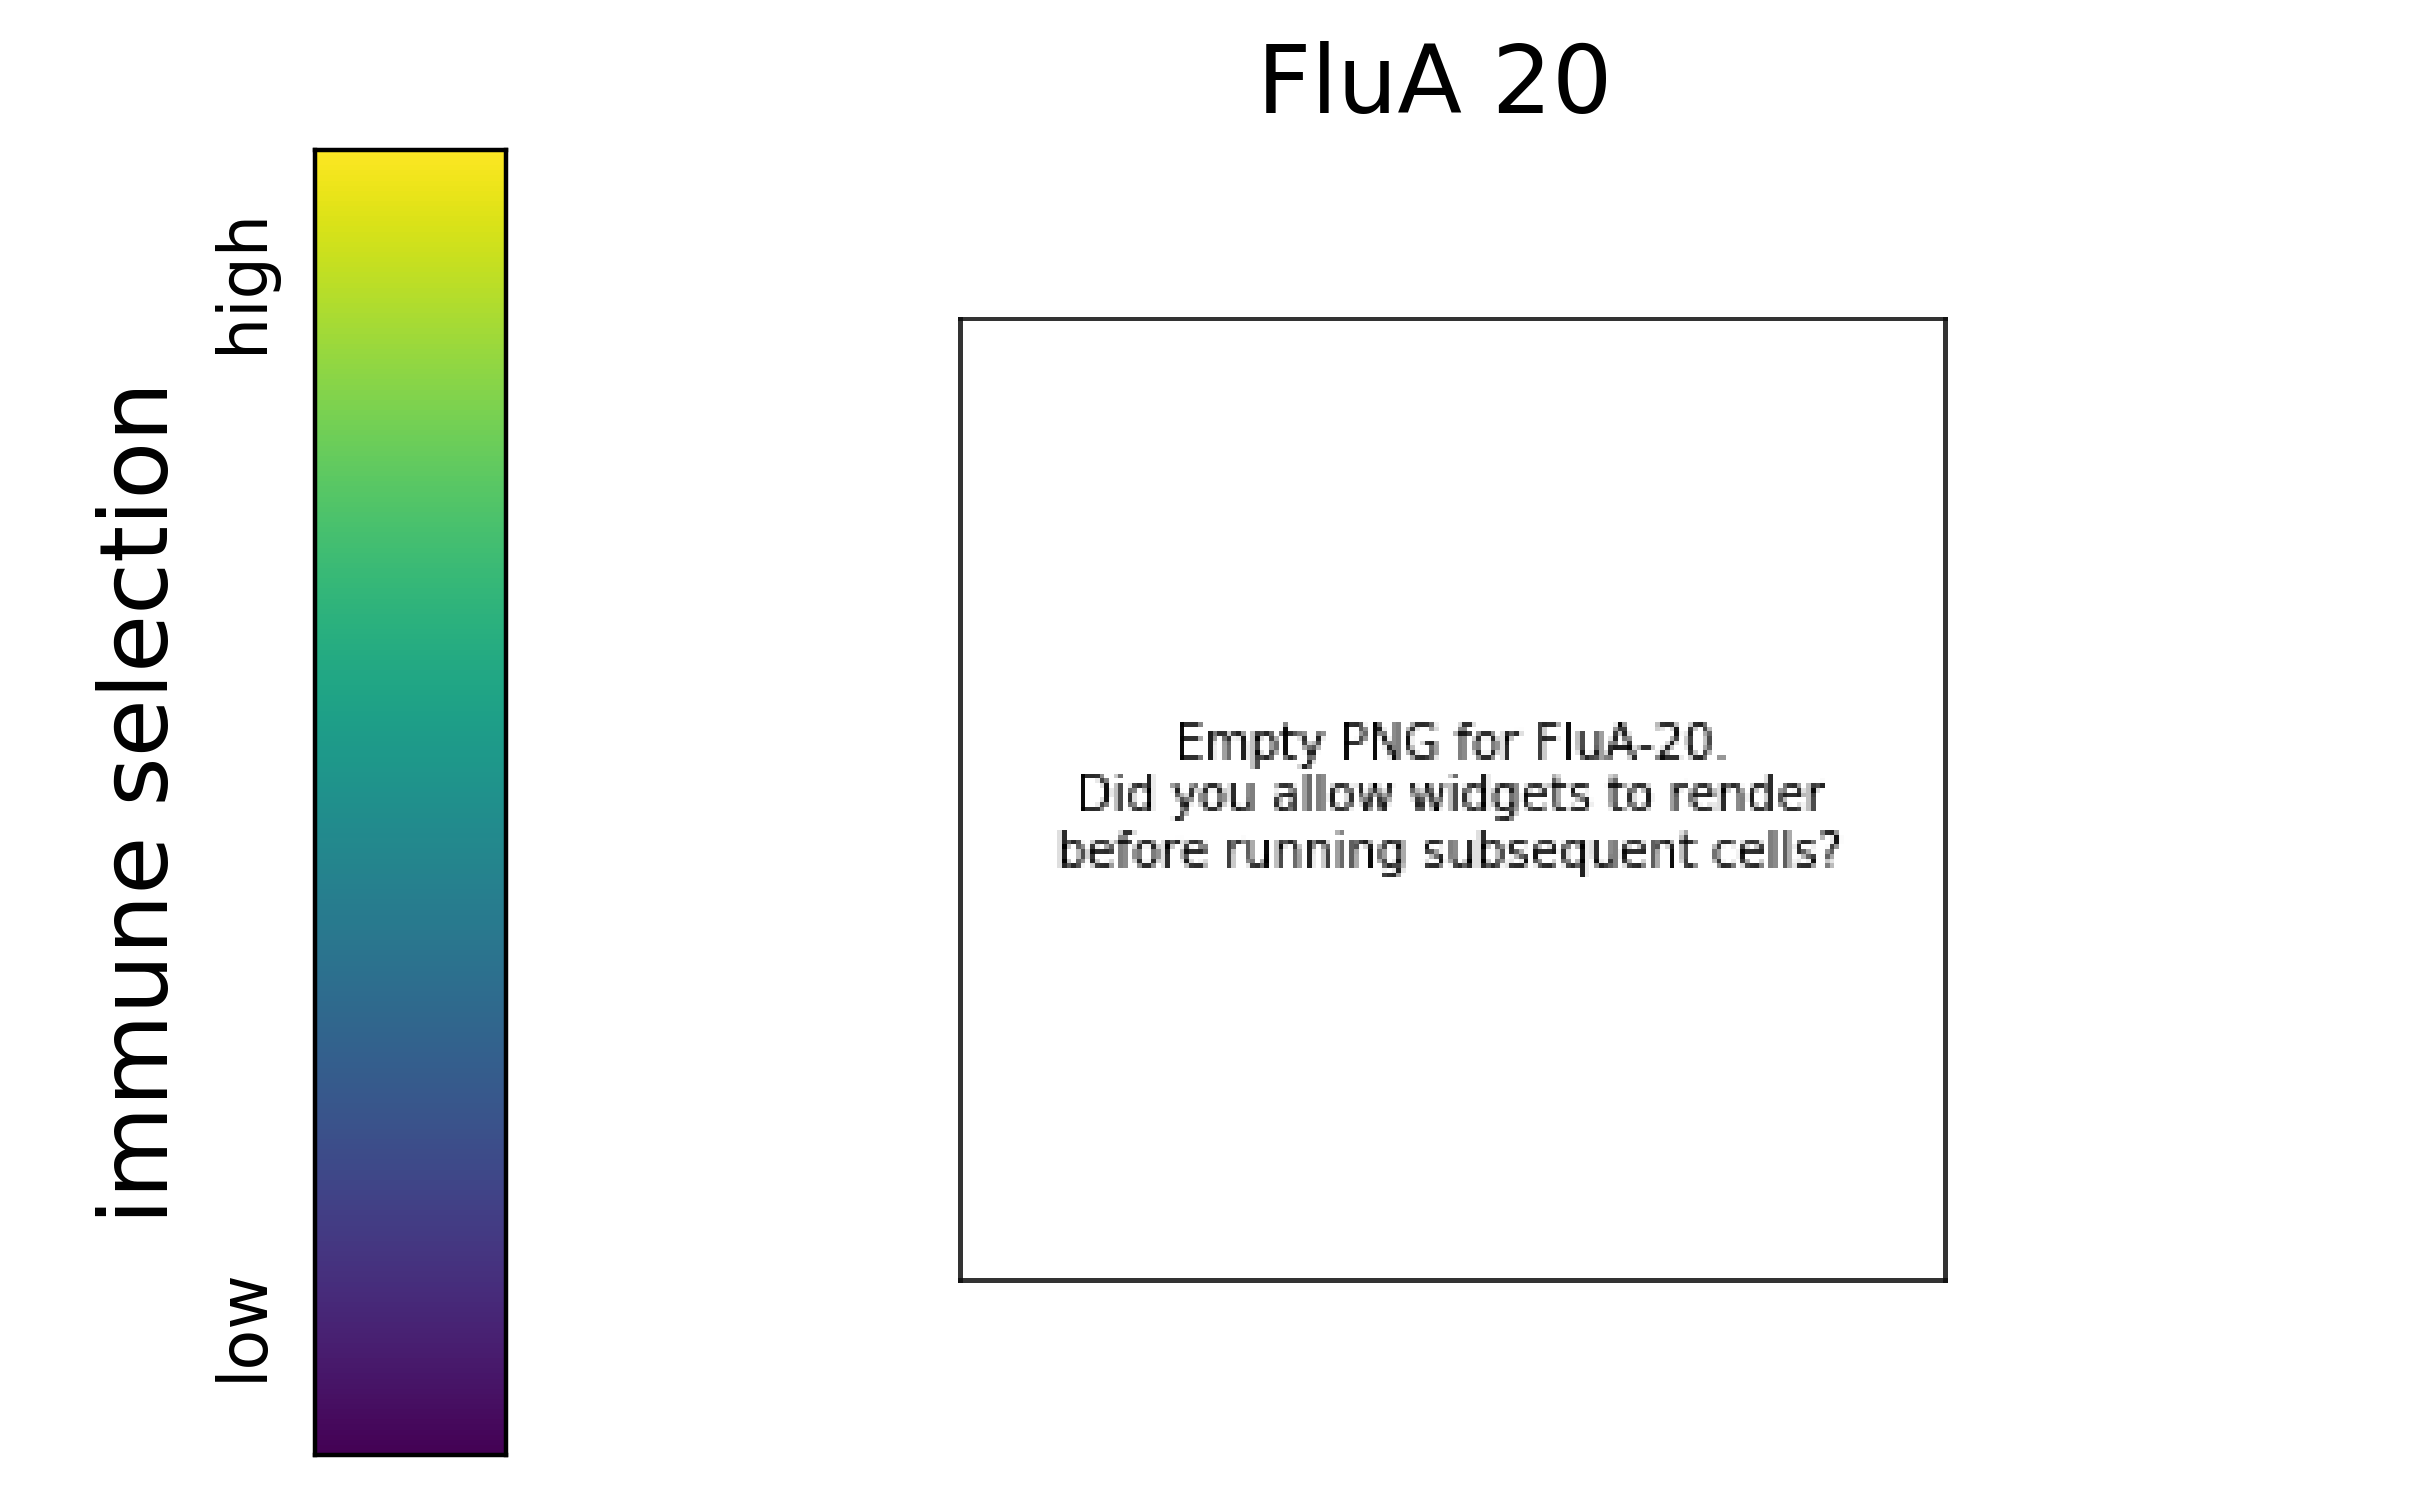

In [28]:
# to look at the PNG of the panel of images, uncomment the line below
display(Image(panel_fig))